
<center><font size=6>Hotel Booking Cancellation Prediction using Data Science</center></font>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, 
VotingClassifier, StackingClassifier)
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, precision_score,
recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve)
from scipy import stats

import warnings
warnings.filterwarnings('ignore') 

pd.set_option("display.float_format", lambda x: "%.2f" % x)

## Load The Dataset

In [2]:
pastdata = pd.read_csv('INNHotelsGroup_pastdata.csv')
newdata  = pd.read_csv('INNHotelsGroup_newdata.csv')

In [3]:
pastdata.head(3)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
0,INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled,NaN
1,INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled,NaN
2,INNHG_101036,24,Online,1,71.69,2,2,2021-01-01,0,0,Not Canceled,NaN


In [4]:
newdata.head(3)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
0,INNHG_128127,4,Online,1,103.00,1,0,2022-07-01,1,1,Not Canceled
1,INNHG_128128,147,Online,2,103.70,2,2,2022-07-01,0,2,Not Canceled
2,INNHG_128129,43,Online,1,126.90,2,1,2022-07-01,1,2,Not Canceled


In [5]:
# Check for duplicates 
pastdata.duplicated(subset=['booking_id']).sum()

0

### Set booking_id as index 

In [6]:
pastdata.set_index('booking_id',inplace=True)

In [7]:
newdata.set_index('booking_id',inplace=True)

## Data Exploration 

In [8]:
# Let's Explore how many cancelled booking were rebooked 

# How many bookings were cancelled 

In [9]:
print(f'Past data and rows {pastdata.shape[0]},columns={pastdata.shape[1]}')

Past data and rows 27093,columns=11


In [10]:
print(f'New data and rows {newdata.shape[0]},columns={newdata.shape[1]}')

New data and rows 3583,columns=10


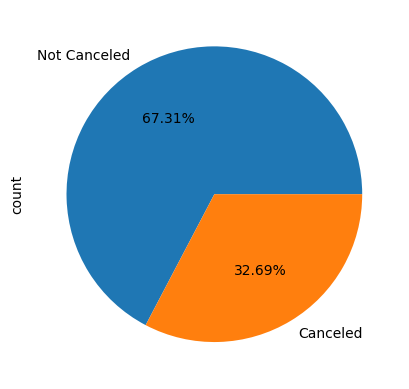

In [11]:
pastdata['booking_status'].value_counts().plot(kind='pie',autopct='%.2f%%')
plt.show()

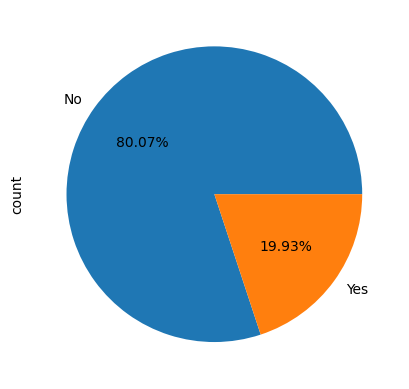

In [12]:
pastdata[pastdata['booking_status']=='Canceled']['rebooked'].value_counts().plot(kind='pie',autopct='%.2f%%')
plt.show()

In [13]:
# We can drop column rebook as it's not required in predictive modeling 

In [14]:
pastdata.drop(columns='rebooked',inplace=True)

In [15]:
# Let's use past data to explore all the columns one by one 

### Univariate Analysis 

In [16]:
pastdata.columns

Index(['lead_time', 'market_segment_type', 'no_of_special_requests',
       'avg_price_per_room', 'no_of_adults', 'no_of_weekend_nights',
       'arrival_date', 'required_car_parking_space', 'no_of_week_nights',
       'booking_status'],
      dtype='object')

In [17]:
num_cols=['lead_time','avg_price_per_room',]
cat_cols=['market_segment_type','no_of_special_requests','no_of_adults','no_of_weekend_nights',
          'required_car_parking_space','no_of_week_nights','booking_status' ]

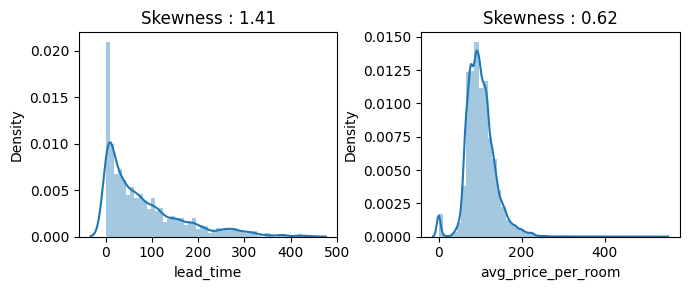

In [18]:
t=1
plt.figure(figsize=(7,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.distplot(pastdata[i])
    plt.title(f'Skewness : {round(pastdata[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

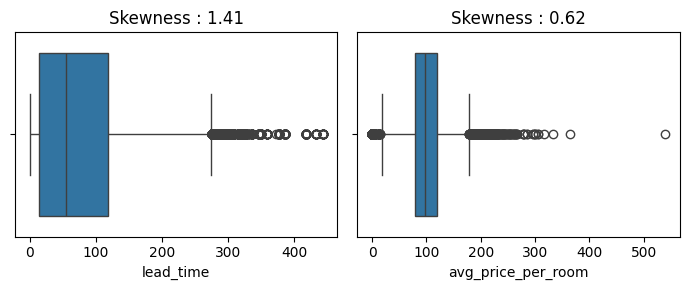

In [19]:
t=1
plt.figure(figsize=(7,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data=pastdata,x=i)
    plt.title(f'Skewness : {round(pastdata[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

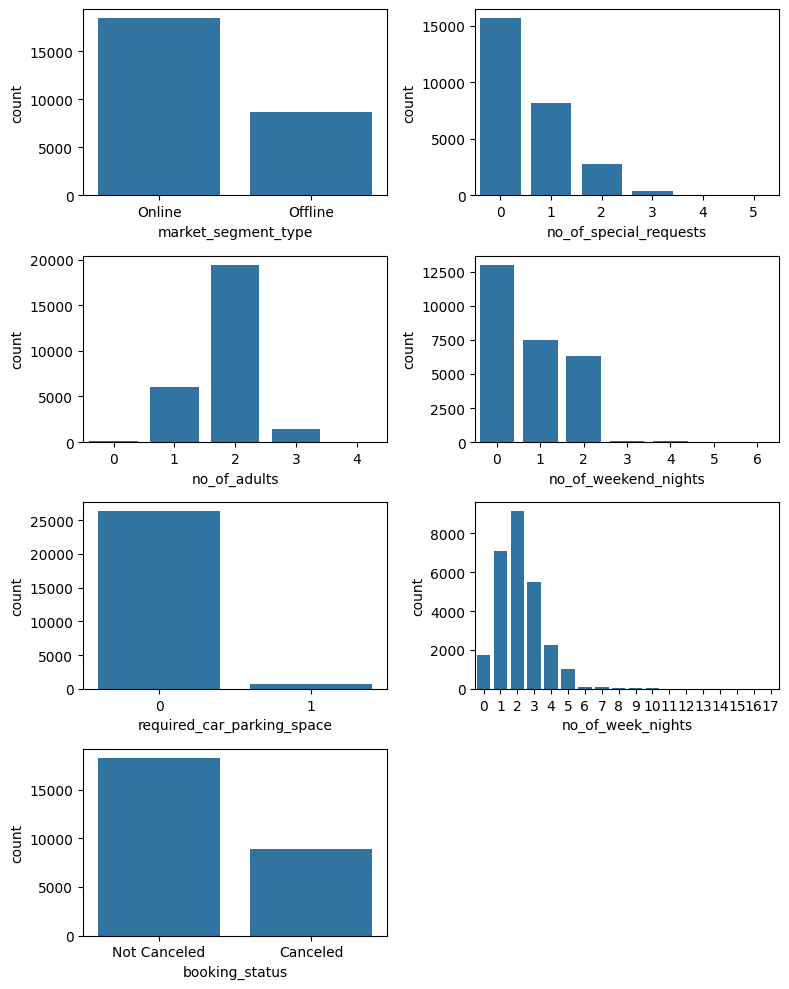

In [20]:
t=1
plt.figure(figsize=(8,10))
for i in cat_cols:
    plt.subplot(4,2,t)
    sns.countplot(data=pastdata,x=i)
    #plt.title(f'Skewness : {round(pastdata[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

## Bivariate Analysis 

In [21]:
# Num vs Cat 

<Figure size 500x500 with 0 Axes>

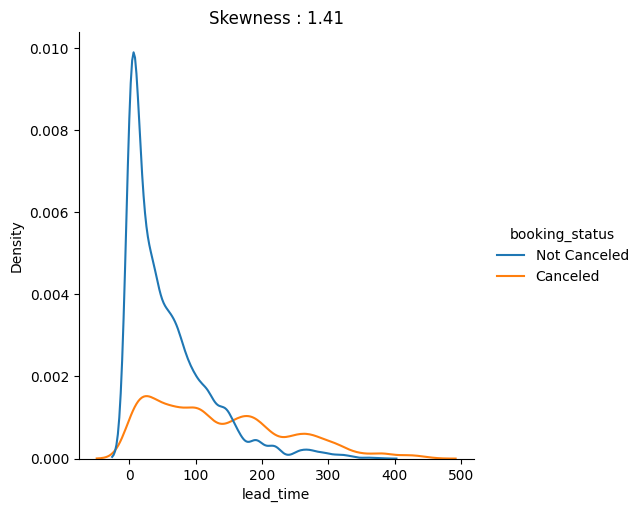

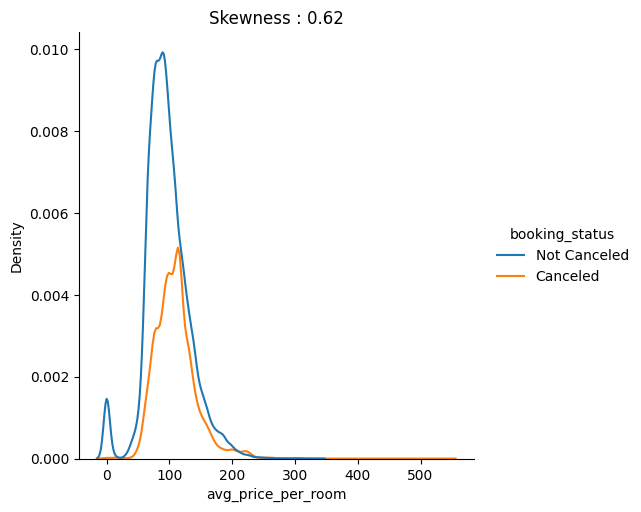

In [22]:
plt.figure(figsize=(5,5))
for i in num_cols:
    sns.displot(data=pastdata,x=i,kind='kde',hue='booking_status')
    plt.title(f'Skewness : {round(pastdata[i].skew(),2)}')
#plt.tight_layout()
plt.show()

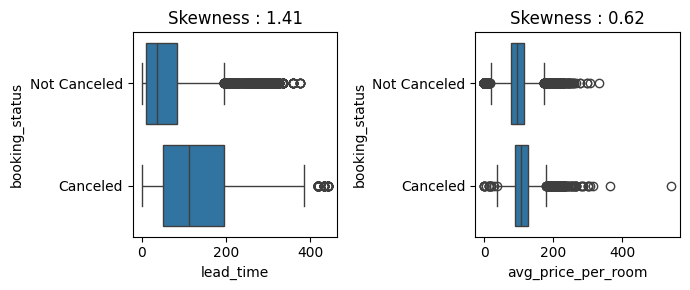

In [23]:
t=1
plt.figure(figsize=(7,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data=pastdata,x=i,y='booking_status')
    plt.title(f'Skewness : {round(pastdata[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

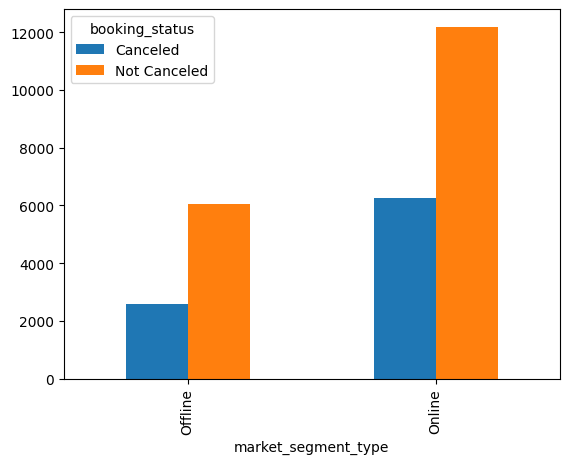

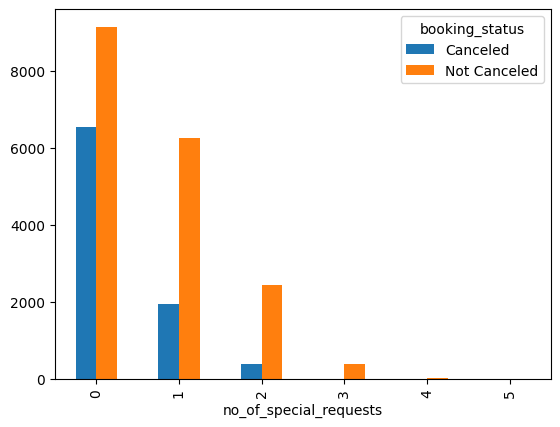

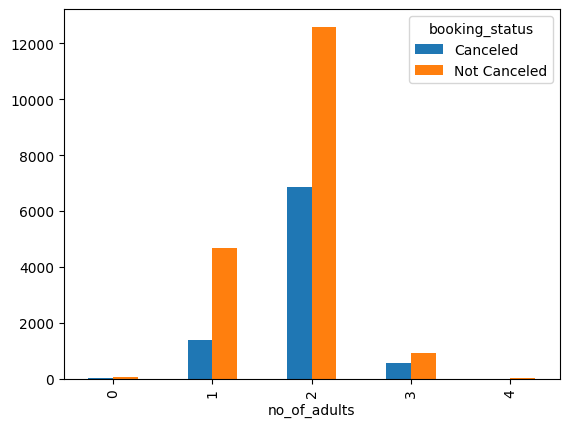

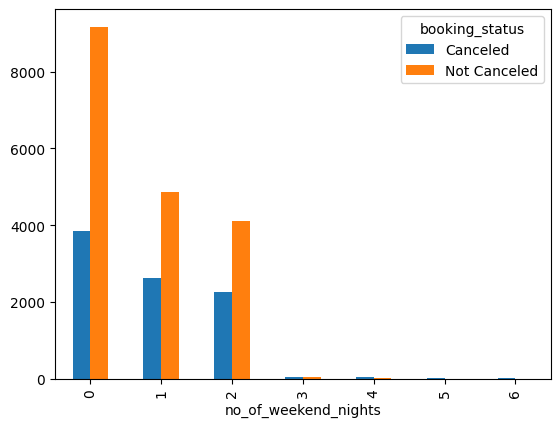

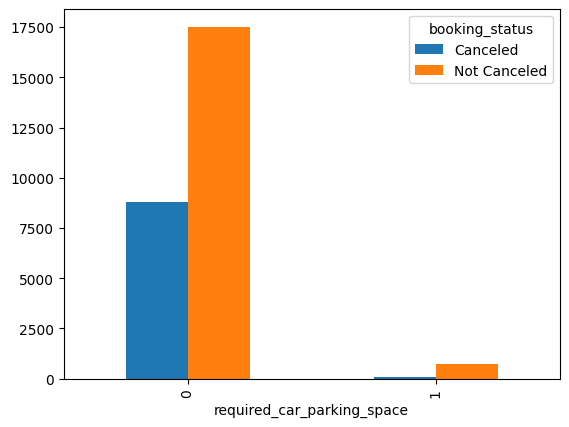

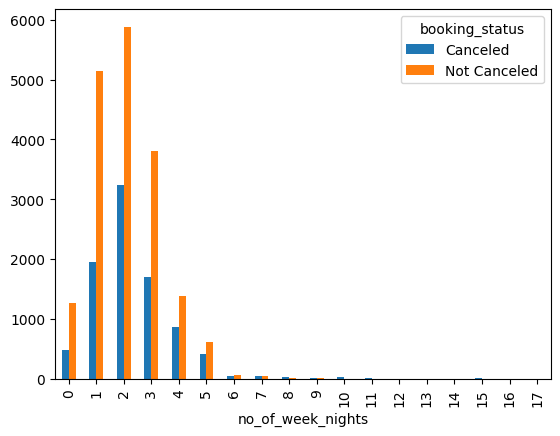

In [24]:
for i in cat_cols:
    if i != 'booking_status':
        pd.crosstab(index=pastdata[i],columns=pastdata['booking_status']).plot(kind='bar')
        plt.show()

## Infrential Statistics 

In [25]:
# To test Bookings With larger lead times are more prone to get cancelled
# mu1 = Average time of cancelled bookings 
# mu2 = Average Lead time of not cancelled bookings.

# Ho: mu1>= mu2
# Ha: mu1 < mu2 

samp1 = pastdata[pastdata['booking_status']=='Canceled']['lead_time']
samp2 = pastdata[pastdata['booking_status']=='Not Canceled']['lead_time']

# Check for assumptions 

#1 : Normality 
print(stats.shapiro(newdata['lead_time']))

#2 : Equal Variances 
print(stats.levene(samp1,samp2))

# The data fails the assumptions we need to use non parametric test (Mannwhiteneyu's test )

tstat,p_value = stats.ttest_ind(samp1,samp2,alternative='less')
if p_value>0.05:
    print('Fail to reject Ho:')
    
else:
    print('Reject Ho ')

ShapiroResult(statistic=0.937125563621521, pvalue=1.6791856804169646e-36)
LeveneResult(statistic=3210.120590252021, pvalue=0.0)
Fail to reject Ho:


## Data Preprocessing

### Check for the deffects 

In [26]:
# Missing Values in pastdata and newdata 

In [27]:
pastdata.isnull().sum().sum()

0

In [28]:
newdata.isnull().sum().sum()

0

In [29]:
# Check for duplicate rows in pastdata

In [30]:
pastdata[pastdata.duplicated()]

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_101079,12,Offline,1,85.00,1,1,2021-01-01,0,0,Not Canceled
INNHG_101094,12,Offline,1,85.00,1,1,2021-01-01,0,0,Not Canceled
INNHG_101097,36,Online,0,110.00,1,2,2021-01-01,0,3,Not Canceled
INNHG_101098,231,Online,1,100.30,2,2,2021-01-01,0,2,Canceled
INNHG_101109,61,Online,1,149.40,2,2,2021-01-01,0,3,Not Canceled
...,...,...,...,...,...,...,...,...,...,...
INNHG_128113,113,Offline,0,85.00,2,1,2022-06-30,0,3,Canceled
INNHG_128115,113,Offline,0,85.00,2,1,2022-06-30,0,3,Canceled
INNHG_128118,113,Offline,0,85.00,2,1,2022-06-30,0,3,Canceled


In [31]:
pastdata.drop_duplicates(inplace=True)

In [32]:
pastdata.shape

(18655, 10)

## Capping  The Extreme  Outliers From the Pastdata

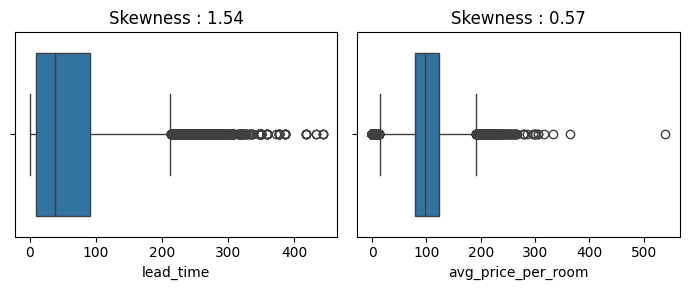

In [33]:
t=1
plt.figure(figsize=(7,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data=pastdata,x=i)
    plt.title(f'Skewness : {round(pastdata[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

In [34]:
for i in num_cols:
    q3,q1=np.percentile(pastdata[i],[75,25])
    iqr=q3-q1
    ul,ll=q3+2*iqr,q1-2*iqr
    pastdata[i]=pastdata[i].apply(lambda x : ul if x > ul else ll if x < ll else x )

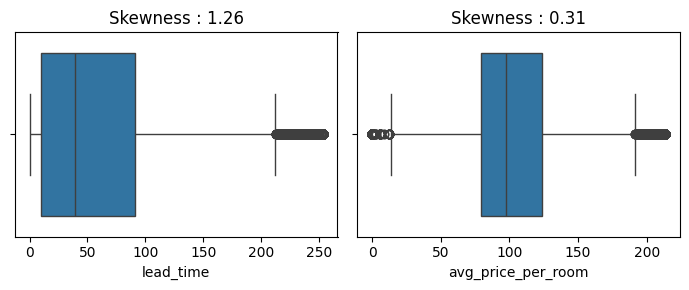

In [35]:
t=1
plt.figure(figsize=(7,3))
for i in num_cols:
    plt.subplot(1,2,t)
    sns.boxplot(data=pastdata,x=i)
    plt.title(f'Skewness : {round(pastdata[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

### Feature Engineering 

In [36]:
pastdata['arrival_date']=pd.to_datetime(pastdata['arrival_date'])
newdata['arrival_date']=pd.to_datetime(newdata['arrival_date'])

In [37]:
pastdata.dtypes

lead_time                            float64
market_segment_type                   object
no_of_special_requests                 int64
avg_price_per_room                   float64
no_of_adults                           int64
no_of_weekend_nights                   int64
arrival_date                  datetime64[ns]
required_car_parking_space             int64
no_of_week_nights                      int64
booking_status                        object
dtype: object

In [38]:
# Feature Engineering on pastdata
pastdata['arrival_day']=pastdata['arrival_date'].dt.day
pastdata['arrival_month']=pastdata['arrival_date'].dt.month
pastdata['arrival_weekday']=pastdata['arrival_date'].dt.weekday

In [39]:
# Feature Engineering on newdata
newdata['arrival_day']=newdata['arrival_date'].dt.day
newdata['arrival_month']=newdata['arrival_date'].dt.month
newdata['arrival_weekday']=newdata['arrival_date'].dt.weekday

In [40]:
# Let's Drop arrival_date from both the datasets 

pastdata.drop(columns=['arrival_date'],inplace=True)
newdata.drop(columns=['arrival_date'],inplace=True)

In [41]:
pastdata.head(2)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,booking_status,arrival_day,arrival_month,arrival_weekday
booking_id,,,,,,,,,,,,
INNHG_101034,0.00,Online,0,85.03,1,1,0,0,Not Canceled,1,1,4
INNHG_101035,34.00,Online,2,125.10,2,2,0,0,Not Canceled,1,1,4


## Encoding

In [42]:
pastdata['market_segment_type']=pastdata['market_segment_type'].map({'Online':1,'Offline':0})
newdata['market_segment_type']=newdata['market_segment_type'].map({'Online':1,'Offline':0})

In [43]:
pastdata['booking_status']=pastdata['booking_status'].map({'Canceled':1,'Not Canceled':0})
newdata['booking_status']=newdata['booking_status'].map({'Canceled':1,'Not Canceled':0})
 

## Train Test Split 

In [44]:
y_train = pastdata['booking_status']
x_train = pastdata.drop(columns='booking_status')
y_test  = newdata['booking_status']
x_test  = newdata.drop(columns='booking_status')

In [45]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(18655, 11) (18655,) (3583, 11) (3583,)


## Predictive Modeling

In [46]:
mod=[]
accu=[]
rec=[]
pre=[]
f1=[]
ckap=[]

def model_validation(model,xtrain,ytrain,xtest,ytest):
    m = model
    m.fit(xtrain,ytrain)
    pred_h = m.predict(xtest)
    pred_s = m.predict_proba(xtest)[:,1]
    
    print('Confusion Matrix:\n',confusion_matrix(ytest,pred_h))
    print('\nClassification Report:\n',classification_report(ytest,pred_h))
    
    fpr,tpr,threshhold=roc_curve(ytest,pred_s)
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],ls='--',color='red')
    plt.title(f'ROC AUC: {round(roc_auc_score(ytest,pred_s),2)}') 
    plt.show()
    
    Ans = input('Do you want to save the result? Y/N: ')
    if Ans.lower()=='y':
        mod.append(str(model))
        accu.append(accuracy_score(ytest,pred_h))
        pre.append(round(precision_score(ytest,pred_h),2))
        rec.append(recall_score(ytest,pred_h))
        f1.append(f1_score(ytest,pred_h))
        ckap.append(cohen_kappa_score(ytest,pred_h))
        global scorecard
        scorecard = pd.DataFrame({'Model':mod,'Accuracy':accu,'Precesion':pre,'Recall':rec,
                                  'F1 Score':f1,'Cohen Kappa':ckap})
        return scorecard
   
    else:
        return

## Tunning

In [47]:
def tuning_parameters(grid,estimator,x,y,score='f1'):
    gscv = GridSearchCV(estimator=estimator,param_grid=grid,verbose=1,scoring=score)
    gscv.fit(x,y)
    return gscv.best_params_

## Class Weights 

In [48]:
y_train.value_counts(normalize=True)

booking_status
0   0.71
1   0.29
Name: proportion, dtype: float64

In [49]:
weights = y_train.shape[0]/(2*y_train.value_counts()[0]),y_train.shape[0]/(2*y_train.value_counts()[1])

In [50]:
weights_dict = {k:v for k,v in zip(range(2),weights)}

In [51]:
weights_dict

{0: 0.7029012810851545, 1: 1.7321262766945218}

### LogisticRegression

Confusion Matrix:
 [[2162  221]
 [ 575  625]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.84      2383
           1       0.74      0.52      0.61      1200

    accuracy                           0.78      3583
   macro avg       0.76      0.71      0.73      3583
weighted avg       0.77      0.78      0.77      3583



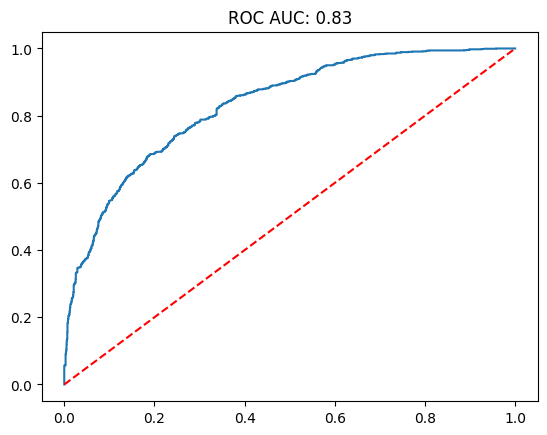

Do you want to save the result? Y/N: Y


,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.78,0.74,0.52,0.61,0.46


In [52]:
model_validation(LogisticRegression(),x_train,y_train,x_test,y_test)

Confusion Matrix:
 [[1742  641]
 [ 289  911]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.73      0.79      2383
           1       0.59      0.76      0.66      1200

    accuracy                           0.74      3583
   macro avg       0.72      0.75      0.73      3583
weighted avg       0.77      0.74      0.75      3583



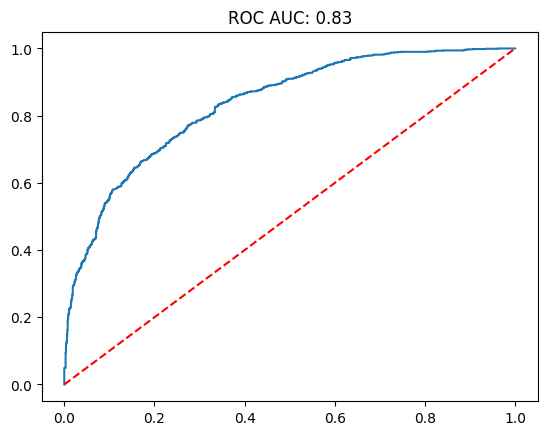

Do you want to save the result? Y/N: Y


,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.78,0.74,0.52,0.61,0.46
1,LogisticRegression(class_weight={0: 0.70290128...,0.74,0.59,0.76,0.66,0.46


In [53]:
model_validation(LogisticRegression(class_weight=weights_dict),x_train,y_train,x_test,y_test)

## Naive Bayes 

Confusion Matrix:
 [[1870  513]
 [ 439  761]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.80      2383
           1       0.60      0.63      0.62      1200

    accuracy                           0.73      3583
   macro avg       0.70      0.71      0.71      3583
weighted avg       0.74      0.73      0.74      3583



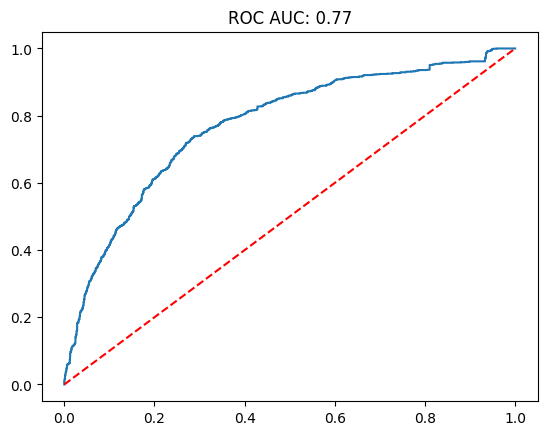

Do you want to save the result? Y/N: Y


,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.78,0.74,0.52,0.61,0.46
1,LogisticRegression(class_weight={0: 0.70290128...,0.74,0.59,0.76,0.66,0.46
2,GaussianNB(),0.73,0.60,0.63,0.62,0.41


In [54]:
model_validation(GaussianNB(),x_train,y_train,x_test,y_test)

Confusion Matrix:
 [[1434  949]
 [ 333  867]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.60      0.69      2383
           1       0.48      0.72      0.57      1200

    accuracy                           0.64      3583
   macro avg       0.64      0.66      0.63      3583
weighted avg       0.70      0.64      0.65      3583



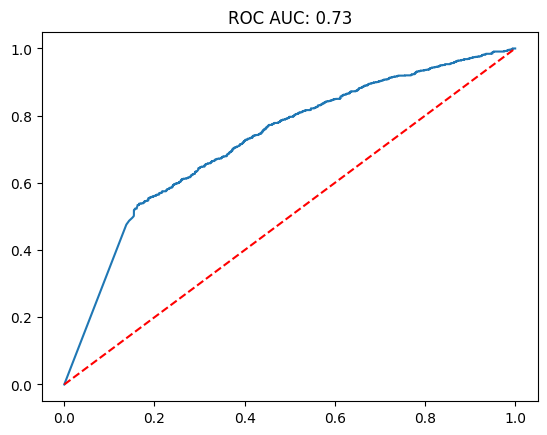

Do you want to save the result? Y/N: Y


,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.78,0.74,0.52,0.61,0.46
1,LogisticRegression(class_weight={0: 0.70290128...,0.74,0.59,0.76,0.66,0.46
2,GaussianNB(),0.73,0.60,0.63,0.62,0.41
3,MultinomialNB(),0.64,0.48,0.72,0.57,0.29


In [55]:
model_validation(MultinomialNB(),x_train,y_train,x_test,y_test)

## Decison Tree

In [56]:
best_dt=tuning_parameters(grid={'max_depth':[3,4,5,6,7,8,9,10]},
                       estimator=DecisionTreeClassifier(),x=x_train,y=y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Confusion Matrix:
 [[1803  580]
 [ 203  997]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.76      0.82      2383
           1       0.63      0.83      0.72      1200

    accuracy                           0.78      3583
   macro avg       0.77      0.79      0.77      3583
weighted avg       0.81      0.78      0.79      3583



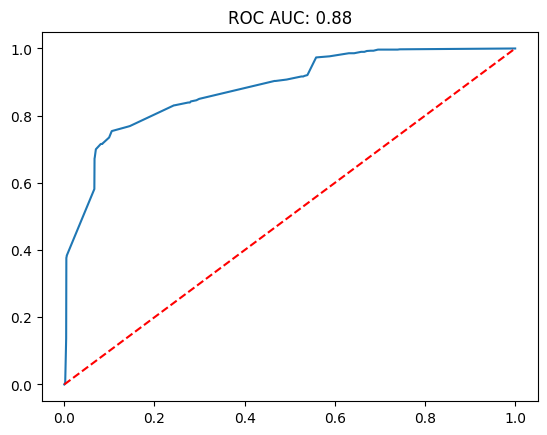

Do you want to save the result? Y/N: Y


,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.78,0.74,0.52,0.61,0.46
1,LogisticRegression(class_weight={0: 0.70290128...,0.74,0.59,0.76,0.66,0.46
2,GaussianNB(),0.73,0.60,0.63,0.62,0.41
3,MultinomialNB(),0.64,0.48,0.72,0.57,0.29
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.78,0.63,0.83,0.72,0.54


In [57]:
model_validation(DecisionTreeClassifier(**best_dt,class_weight=weights_dict),x_train,y_train,x_test,y_test)

## Random Forest 

In [58]:
best_rf=tuning_parameters(grid={'max_depth':[3,4,5,6,7],'n_estimators':[80,100,120]},
                       estimator=RandomForestClassifier(max_features=None,class_weight=weights_dict),x=x_train,y=y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


Confusion Matrix:
 [[2173  210]
 [ 310  890]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89      2383
           1       0.81      0.74      0.77      1200

    accuracy                           0.85      3583
   macro avg       0.84      0.83      0.83      3583
weighted avg       0.85      0.85      0.85      3583



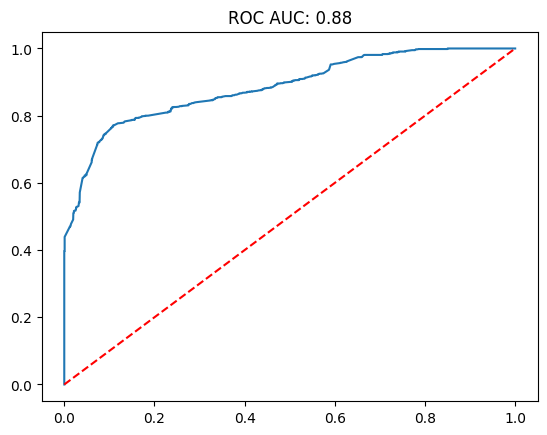

Do you want to save the result? Y/N: Y


,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.78,0.74,0.52,0.61,0.46
1,LogisticRegression(class_weight={0: 0.70290128...,0.74,0.59,0.76,0.66,0.46
2,GaussianNB(),0.73,0.60,0.63,0.62,0.41
3,MultinomialNB(),0.64,0.48,0.72,0.57,0.29
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.78,0.63,0.83,0.72,0.54
5,"RandomForestClassifier(max_depth=5, max_featur...",0.85,0.81,0.74,0.77,0.67


In [59]:
model_validation(RandomForestClassifier(**best_rf,max_features=None),x_train,y_train,x_test,y_test)

## Ada Boost 

In [60]:
best_ada = tuning_parameters(grid={'n_estimators':[50,70,100,120,150],'learning_rate':[0.1,0.5]},
                            estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight=weights_dict)),
                             x=x_train,y=y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [61]:
best_ada

{'learning_rate': 0.5, 'n_estimators': 120}

Confusion Matrix:
 [[1942  441]
 [ 395  805]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      2383
           1       0.65      0.67      0.66      1200

    accuracy                           0.77      3583
   macro avg       0.74      0.74      0.74      3583
weighted avg       0.77      0.77      0.77      3583



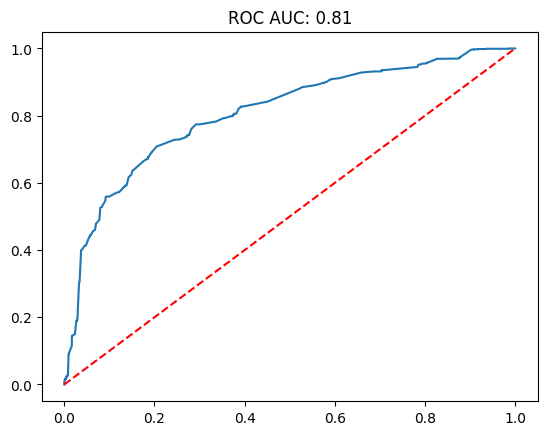

Do you want to save the result? Y/N: Y


,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.78,0.74,0.52,0.61,0.46
1,LogisticRegression(class_weight={0: 0.70290128...,0.74,0.59,0.76,0.66,0.46
2,GaussianNB(),0.73,0.60,0.63,0.62,0.41
3,MultinomialNB(),0.64,0.48,0.72,0.57,0.29
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.78,0.63,0.83,0.72,0.54
5,"RandomForestClassifier(max_depth=5, max_featur...",0.85,0.81,0.74,0.77,0.67
6,AdaBoostClassifier(estimator=DecisionTreeClass...,0.77,0.65,0.67,0.66,0.48


In [62]:
model_validation(AdaBoostClassifier(**best_ada,estimator=DecisionTreeClassifier(class_weight=weights_dict)),x_train,
                y_train,x_test,y_test)

## Gradient Boosting 

In [63]:
best_gbm=tuning_parameters(grid={'n_estimators':[70,100,120],'learning_rate':[0.1,0.5],'max_depth':[3,5,7]},
                          estimator=GradientBoostingClassifier(),x=x_train,y=y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [64]:
best_gbm

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 70}

Confusion Matrix:
 [[2082  301]
 [ 306  894]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      2383
           1       0.75      0.74      0.75      1200

    accuracy                           0.83      3583
   macro avg       0.81      0.81      0.81      3583
weighted avg       0.83      0.83      0.83      3583



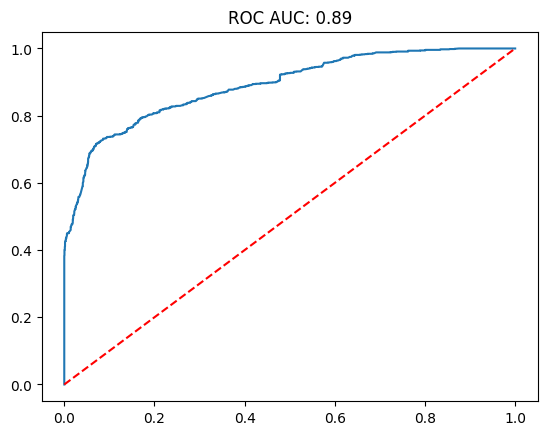

Do you want to save the result? Y/N: Y


,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.78,0.74,0.52,0.61,0.46
1,LogisticRegression(class_weight={0: 0.70290128...,0.74,0.59,0.76,0.66,0.46
2,GaussianNB(),0.73,0.60,0.63,0.62,0.41
3,MultinomialNB(),0.64,0.48,0.72,0.57,0.29
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.78,0.63,0.83,0.72,0.54
5,"RandomForestClassifier(max_depth=5, max_featur...",0.85,0.81,0.74,0.77,0.67
6,AdaBoostClassifier(estimator=DecisionTreeClass...,0.77,0.65,0.67,0.66,0.48
7,GradientBoostingClassifier(n_estimators=70),0.83,0.75,0.74,0.75,0.62


In [65]:
model_validation(GradientBoostingClassifier(**best_gbm),x_train,
                y_train,x_test,y_test)

## XG Boost 

In [66]:
best_xgb=tuning_parameters(grid={'n_estimators':[70,100,120],'learning_rate':[0.1,0.5],'gamma':[1,2,3]},
                          estimator=XGBClassifier(),x=x_train,y=y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [67]:
best_xgb

{'gamma': 3, 'learning_rate': 0.1, 'n_estimators': 70}

Confusion Matrix:
 [[2052  331]
 [ 302  898]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.87      2383
           1       0.73      0.75      0.74      1200

    accuracy                           0.82      3583
   macro avg       0.80      0.80      0.80      3583
weighted avg       0.82      0.82      0.82      3583



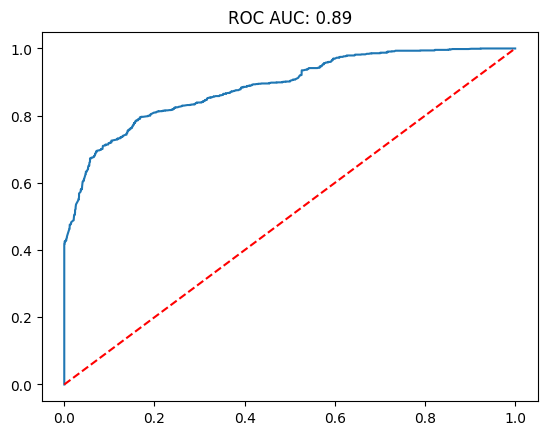

Do you want to save the result? Y/N: Y


,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.78,0.74,0.52,0.61,0.46
1,LogisticRegression(class_weight={0: 0.70290128...,0.74,0.59,0.76,0.66,0.46
2,GaussianNB(),0.73,0.60,0.63,0.62,0.41
3,MultinomialNB(),0.64,0.48,0.72,0.57,0.29
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.78,0.63,0.83,0.72,0.54
5,"RandomForestClassifier(max_depth=5, max_featur...",0.85,0.81,0.74,0.77,0.67
6,AdaBoostClassifier(estimator=DecisionTreeClass...,0.77,0.65,0.67,0.66,0.48
7,GradientBoostingClassifier(n_estimators=70),0.83,0.75,0.74,0.75,0.62
8,"XGBClassifier(base_score=None, booster=None, c...",0.82,0.73,0.75,0.74,0.61


In [68]:
model_validation(XGBClassifier(**best_gbm),x_train,
                y_train,x_test,y_test)

## Voting

Confusion Matrix:
 [[2018  365]
 [ 269  931]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.86      2383
           1       0.72      0.78      0.75      1200

    accuracy                           0.82      3583
   macro avg       0.80      0.81      0.81      3583
weighted avg       0.83      0.82      0.82      3583



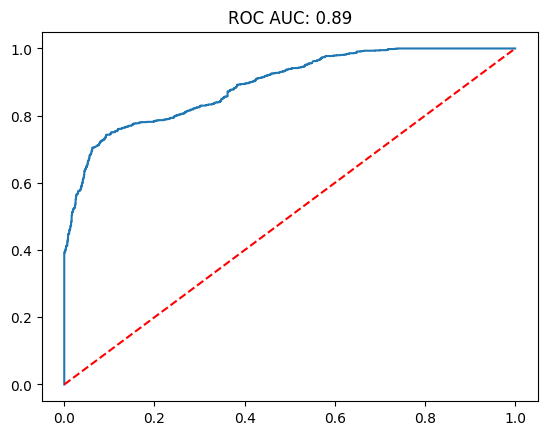

Do you want to save the result? Y/N: Y


,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.78,0.74,0.52,0.61,0.46
1,LogisticRegression(class_weight={0: 0.70290128...,0.74,0.59,0.76,0.66,0.46
2,GaussianNB(),0.73,0.60,0.63,0.62,0.41
3,MultinomialNB(),0.64,0.48,0.72,0.57,0.29
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.78,0.63,0.83,0.72,0.54
5,"RandomForestClassifier(max_depth=5, max_featur...",0.85,0.81,0.74,0.77,0.67
6,AdaBoostClassifier(estimator=DecisionTreeClass...,0.77,0.65,0.67,0.66,0.48
7,GradientBoostingClassifier(n_estimators=70),0.83,0.75,0.74,0.75,0.62
8,"XGBClassifier(base_score=None, booster=None, c...",0.82,0.73,0.75,0.74,0.61
9,"VotingClassifier(estimators=[('DT',\n ...",0.82,0.72,0.78,0.75,0.61


In [69]:
base_estimators =  [('DT',DecisionTreeClassifier(**best_dt,class_weight=weights_dict)),
                    ('RF',RandomForestClassifier(**best_rf,class_weight=weights_dict)),
                    ('GBM',GradientBoostingClassifier(**best_gbm)),
                    ('XGB',XGBClassifier(**best_xgb))]
model_validation(VotingClassifier(estimators=base_estimators,voting='soft'),x_train,y_train,x_test,y_test)

## Stacking

Confusion Matrix:
 [[1905  478]
 [ 260  940]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84      2383
           1       0.66      0.78      0.72      1200

    accuracy                           0.79      3583
   macro avg       0.77      0.79      0.78      3583
weighted avg       0.81      0.79      0.80      3583



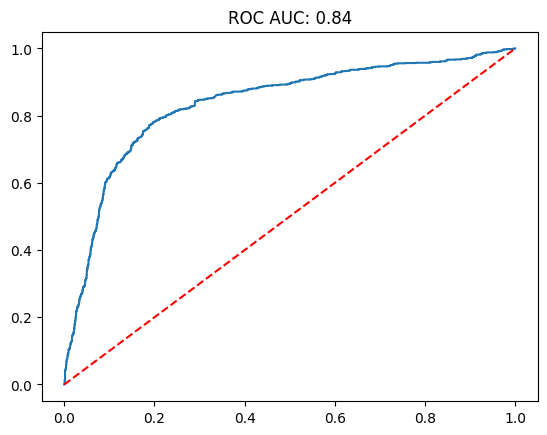

Do you want to save the result? Y/N: Y


,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.78,0.74,0.52,0.61,0.46
1,LogisticRegression(class_weight={0: 0.70290128...,0.74,0.59,0.76,0.66,0.46
2,GaussianNB(),0.73,0.60,0.63,0.62,0.41
3,MultinomialNB(),0.64,0.48,0.72,0.57,0.29
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.78,0.63,0.83,0.72,0.54
5,"RandomForestClassifier(max_depth=5, max_featur...",0.85,0.81,0.74,0.77,0.67
6,AdaBoostClassifier(estimator=DecisionTreeClass...,0.77,0.65,0.67,0.66,0.48
7,GradientBoostingClassifier(n_estimators=70),0.83,0.75,0.74,0.75,0.62
8,"XGBClassifier(base_score=None, booster=None, c...",0.82,0.73,0.75,0.74,0.61
9,"VotingClassifier(estimators=[('DT',\n ...",0.82,0.72,0.78,0.75,0.61


In [70]:
model_validation(StackingClassifier(estimators=base_estimators,
                                    final_estimator=LogisticRegression(class_weight=weights_dict)),
                                     x_train,y_train,x_test,y_test)

## Final Model 

In [71]:
best_xgb

{'gamma': 3, 'learning_rate': 0.1, 'n_estimators': 70}

In [72]:
grid = {'gamma':[3,4,5,6],
       'learning_rate':[0.5,0.2,0.1,1],
       'n_estimators':[65,70,75,80,85,100]}

In [73]:
final_xgb= tuning_parameters(grid=grid,estimator=XGBClassifier(),x=x_train,y=y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [74]:
final_xgb

{'gamma': 5, 'learning_rate': 0.1, 'n_estimators': 75}

Confusion Matrix:
 [[2039  344]
 [ 307  893]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86      2383
           1       0.72      0.74      0.73      1200

    accuracy                           0.82      3583
   macro avg       0.80      0.80      0.80      3583
weighted avg       0.82      0.82      0.82      3583



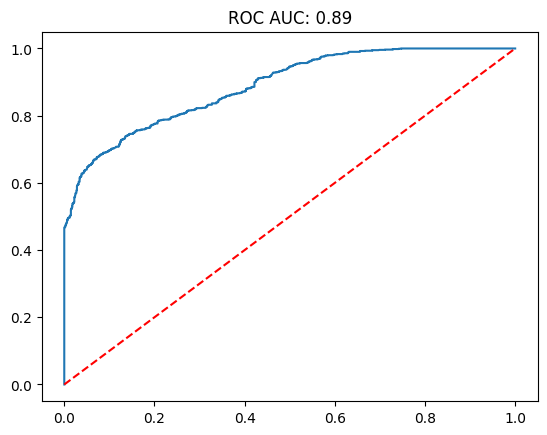

Do you want to save the result? Y/N: Y


,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.78,0.74,0.52,0.61,0.46
1,LogisticRegression(class_weight={0: 0.70290128...,0.74,0.59,0.76,0.66,0.46
2,GaussianNB(),0.73,0.60,0.63,0.62,0.41
3,MultinomialNB(),0.64,0.48,0.72,0.57,0.29
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.78,0.63,0.83,0.72,0.54
5,"RandomForestClassifier(max_depth=5, max_featur...",0.85,0.81,0.74,0.77,0.67
6,AdaBoostClassifier(estimator=DecisionTreeClass...,0.77,0.65,0.67,0.66,0.48
7,GradientBoostingClassifier(n_estimators=70),0.83,0.75,0.74,0.75,0.62
8,"XGBClassifier(base_score=None, booster=None, c...",0.82,0.73,0.75,0.74,0.61
9,"VotingClassifier(estimators=[('DT',\n ...",0.82,0.72,0.78,0.75,0.61


In [75]:
model_validation(XGBClassifier(**final_xgb),x_train,y_train,x_test,y_test)

In [76]:
final_model = XGBClassifier(**final_xgb)

In [77]:
final_model.fit(x_test,y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Confusion Matrix:
 [[2039  344]
 [ 307  893]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86      2383
           1       0.72      0.74      0.73      1200

    accuracy                           0.82      3583
   macro avg       0.80      0.80      0.80      3583
weighted avg       0.82      0.82      0.82      3583



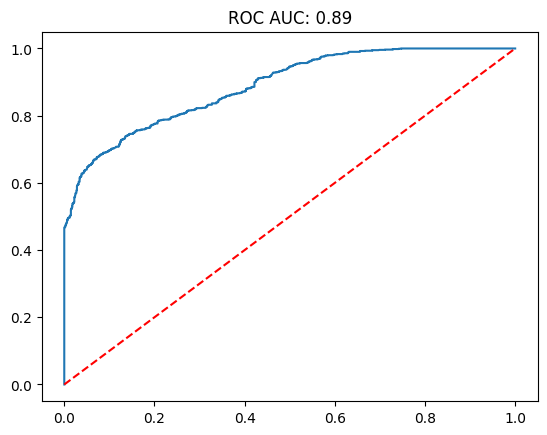

Do you want to save the result? Y/N: Y


,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.78,0.74,0.52,0.61,0.46
1,LogisticRegression(class_weight={0: 0.70290128...,0.74,0.59,0.76,0.66,0.46
2,GaussianNB(),0.73,0.60,0.63,0.62,0.41
3,MultinomialNB(),0.64,0.48,0.72,0.57,0.29
4,DecisionTreeClassifier(class_weight={0: 0.7029...,0.78,0.63,0.83,0.72,0.54
5,"RandomForestClassifier(max_depth=5, max_featur...",0.85,0.81,0.74,0.77,0.67
6,AdaBoostClassifier(estimator=DecisionTreeClass...,0.77,0.65,0.67,0.66,0.48
7,GradientBoostingClassifier(n_estimators=70),0.83,0.75,0.74,0.75,0.62
8,"XGBClassifier(base_score=None, booster=None, c...",0.82,0.73,0.75,0.74,0.61
9,"VotingClassifier(estimators=[('DT',\n ...",0.82,0.72,0.78,0.75,0.61


In [78]:
model_validation(final_model,x_train,y_train,x_test,y_test)

## Business Interpretations

In [83]:
fi=final_model.feature_importances_

In [84]:
fi_data=pd.DataFrame({'Feature Importance':fi},index=x_train.columns).sort_values(by='Feature Importance',ascending=False)

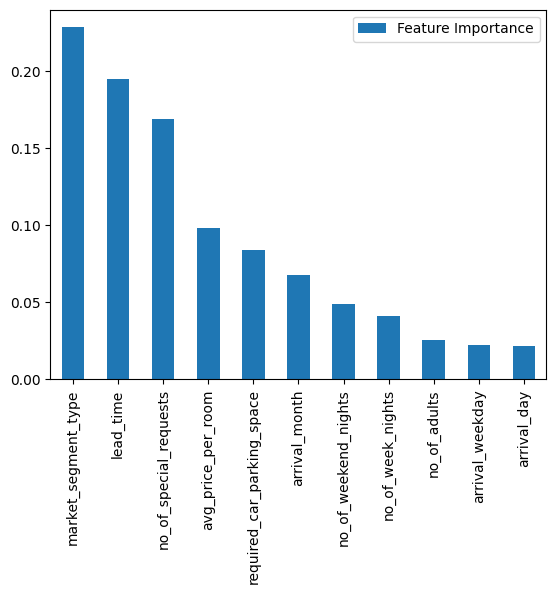

In [85]:
fi_data.plot(kind='bar')
plt.show()

## Deployment 

In [86]:
# Save the final model as a pickle file 

with open('Final_model_xgb.pkl','wb') as file:
    pickle.dump(final_model,file)